In [92]:
import numpy as np
import pandas as pd
import csv 
import scipy
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import itertools
 
from scipy import ndimage
from skimage.io import imread, imshow 
from PIL import Image  
from keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix , classification_report

In [93]:
def read_image(name): 
  img = imread(name)
  img = img.reshape((-1, 1090, 1600, 3))
  return img

In [94]:
def flip(image, n_new_img):
  new_Images = []
  # ImageDataGenerator flipping
  datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

  # iterator
  aug_iter = datagen.flow(image, batch_size=1)
  # generate batch of images
  for i in range(n_new_img):
    image = next(aug_iter)[0].astype('uint8')
    new_Images.append(image)
  return new_Images

In [95]:
def Rotation(image, n_new_img, rotating_factor):
  new_Images = []
  # ImageDataGenerator rotation
  datagen = ImageDataGenerator(rotation_range=rotating_factor, fill_mode='nearest')

  # iterator
  aug_iter = datagen.flow(image, batch_size=1)

  # generate batch of images
  for i in range(n_new_img):
    image = next(aug_iter)[0].astype('uint8')
    new_Images.append(image)
  return new_Images


In [96]:
def Scale(image, zoom_factor, n_new_img):
  new_Images = []
  # ImageDataGenerator zooming
  datagen = ImageDataGenerator(zoom_range=zoom_factor)

  # iterator
  aug_iter = datagen.flow(image, batch_size=1)
  # generate batch of images
  for i in range(n_new_img):
    image = next(aug_iter)[0].astype('uint8')
    new_Images.append(image)
  return new_Images

In [97]:
def Brightness(image, _brightness_range, n_new_img):
  new_Images = []
  # ImageDataGenerator brightness
  datagen = ImageDataGenerator(brightness_range=_brightness_range)

  # iterator
  aug_iter = datagen.flow(image, batch_size=1)

  for i in range(n_new_img):
    image = next(aug_iter)[0].astype('uint8')
    new_Images.append(image)
  return new_Images

In [98]:
def plot_image(images, n_images):
  # generate samples and plot
  fig, ax = plt.subplots(nrows=1, ncols=n_images, figsize=(15,15))
  for i in range(n_images):
    ax[i].imshow(images[i])
    ax[i].axis('off')

In [99]:
image = read_image('test.jpg')

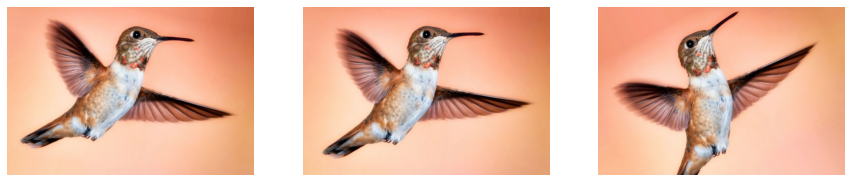

In [100]:
images = Rotation(image, n_new_img=3, rotating_factor=30)
plot_image(images, n_images=3)

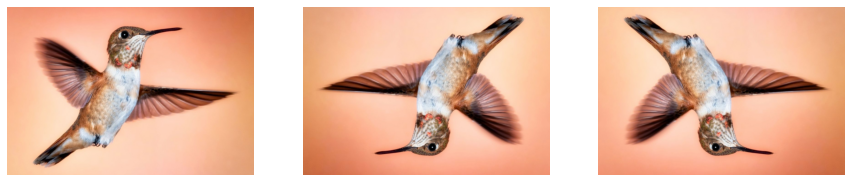

In [101]:
images = flip(image, n_new_img=3)
plot_image(images, n_images=3)

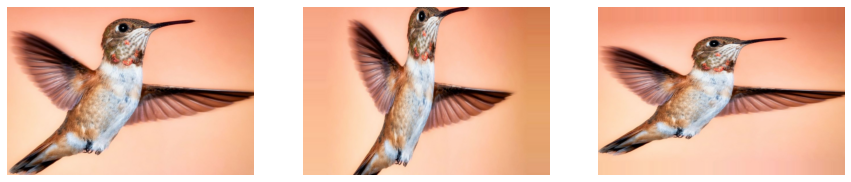

In [102]:
images = Scale(image, zoom_factor=0.3, n_new_img=3)
plot_image(images, n_images=3)

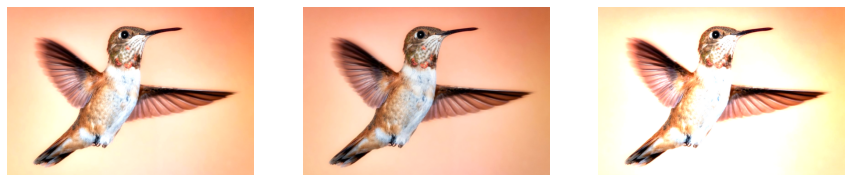

In [103]:
images = Brightness(image, _brightness_range=[0.4,1.5], n_new_img=3)
plot_image(images, n_images=3)

# Part #3: Cifar10

Importing Dataset

In [104]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2021-05-15 12:45:14--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.1’

cifar-10-python.tar 100%[===================>] 162.60M  98.8MB/s    in 1.6s    

2021-05-15 12:45:16 (98.8 MB/s) - ‘cifar-10-python.tar.gz.1’ saved [170498071/170498071]



In [105]:
!tar -xvf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [106]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [107]:
metadata = unpickle('cifar-10-batches-py/batches.meta')[b'label_names']

In [108]:
index2label = {
    index: label.decode('ascii') for index, label in enumerate(metadata)
}
index2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [109]:
data = unpickle('cifar-10-batches-py/data_batch_1')
print(data.keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [110]:
test = unpickle('cifar-10-batches-py/test_batch')
print(test.keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [111]:
data_array = data[b'data']
data_array = np.reshape(data_array, (10000, 3, 1024))

test_array = test[b'data']
test_array = np.reshape(test_array, (10000, 3, 1024))

In [112]:
data_labels = data[b'labels']
data_labels = np.array(data_labels)

test_labels = test[b'labels']
test_labels = np.array(test_labels)

In [113]:
data_array_agg = np.array([])
data_labels_agg = np.array([])
base_path = 'cifar-10-batches-py'
file_names = os.listdir(base_path)
for file_name in file_names:
    if file_name.startswith('data_batch'):

        data = unpickle(os.path.join(base_path, file_name))
        data_array = data[b'data']
        data_array = np.reshape(data_array, (10000, 3, 1024))
        data_labels = data[b'labels']
        data_labels = np.array(data_labels)
        if data_array_agg.shape == (0, ):
            data_array_agg = data_array
            data_labels_agg = data_labels
        else: 
            data_array_agg = np.append(data_array_agg, data_array, axis=0)
            data_labels_agg = np.append(data_labels_agg, data_labels, axis=0)
data_array_agg = data_array_agg.reshape((-1, 3, 32, 32))            

In [114]:
data_array_agg.shape, data_labels_agg.shape

((50000, 3, 32, 32), (50000,))

In [115]:
test_array_agg = np.array([])
test_labels_agg = np.array([])
base_path = 'cifar-10-batches-py'
file_names = os.listdir(base_path)
for file_name in file_names:
    if file_name.startswith('test_batch'):

        test = unpickle(os.path.join(base_path, file_name))
        test_array = test[b'data']
        test_array = np.reshape(test_array, (10000, 3, 1024))
        test_labels = test[b'labels']
        test_labels = np.array(test_labels)
        if test_array_agg.shape == (0, ):
            test_array_agg = test_array
            test_labels_agg = test_labels
        else: 
            test_array_agg = np.append(test_array_agg, test_array, axis=0)
            test_labels_agg = np.append(test_labels_agg, test_labels, axis=0)
test_array_agg = test_array_agg.reshape((-1, 3, 32, 32))

In [116]:
test_data = unpickle(os.path.join(base_path, 'test_batch'))
test_data_array = test_data[b'data']
test_data_array = np.reshape(test_data_array, (10000, 3, 1024))
test_data_labels = test_data[b'labels']
test_data_labels = np.array(test_data_labels)
test_data_array = test_data_array.reshape((-1, 3, 32, 32))

In [117]:
test_data_array.shape, test_data_labels.shape

((10000, 3, 32, 32), (10000,))

### Converting the numpy arrays to the torch Data

In [118]:
def to_dataloader(data_array_agg, data_labels_agg, batch_size, normalizer=255.0):
    target = torch.tensor(data_labels_agg)
    data_array_agg = data_array_agg / normalizer
    data = torch.tensor(data_array_agg.astype(np.float32))

    data_tensor = torch.utils.data.TensorDataset(data, target)
    data_loader = DataLoader(data_tensor, shuffle=True, batch_size=batch_size)
    return data_loader

In [119]:
train_data_loader = to_dataloader(reduced_data_array_agg, reduced_data_labels_agg, batch_size=128)
test_data_loader = to_dataloader(test_array_agg, test_labels_agg, batch_size=128)

In [120]:
for data_array, target in train_data_loader:
    print('the shape of the data array: {}'.format(data_array.shape))
    print('the shape of the target array: {}'.format(target.shape))
    break

the shape of the data array: torch.Size([128, 3, 32, 32])
the shape of the target array: torch.Size([128])


### Building the Model

In [121]:
# model with 3 convolutional hidden layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool(self.base(x))
        out = self.pool(self.layer1(out))
        out = self.pool(self.layer2(out))

        out = out.reshape((out.size(0), -1))
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = self.fc5(out)
        return out

### Utility Functions for Training and Evaluating the Model and also Visualization

In [122]:
def plot_train_test_acc(train_acc, test_acc):
    fig = plt.figure(figsize=(10, 6))
    plt.plot(train_acc, color='salmon', label='train accuracy', marker='o', linewidth=1)
    plt.annotate(str(np.round(train_acc[-1], 1)) + '%', (len(train_acc) - .8, train_acc[-1]), color='salmon')
    plt.plot(test_acc, color='skyblue', label='test accuracy', marker='o', linewidth=1)
    plt.annotate(str(np.round(test_acc[-1], 1)) + '%', (len(test_acc) - .8, test_acc[-1]), color='skyblue')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend()

In [123]:
def check_accuracy(model, loader):
    correct = 0
    total = 0
    model.eval()
    outputs_agg = np.array([])
    targets_agg = np.array([])
    with torch.no_grad():
        for images, labels in loader:
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            outputs_agg = np.append(outputs_agg, predicted.numpy())
            targets_agg = np.append(targets_agg, labels.numpy())
    model.train()
    acc = (100 * correct / total)
    return acc, outputs_agg, targets_agg

In [124]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### Training the Network

In [125]:
def train(model, criterion, optimizer, trainloader, testloader, n_epochs):
    train_epochs_acc = []
    test_epochs_acc = []
    for epoch in tqdm(range(n_epochs), leave=False):
        
        for inputs, labels in tqdm(trainloader, leave=False):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        train_acc, _, _ = check_accuracy(model, trainloader)
        test_acc, pred_test, target_test = check_accuracy(model, testloader)

        train_epochs_acc.append(train_acc)
        test_epochs_acc.append(test_acc)

    
    return train_epochs_acc, test_epochs_acc, pred_test, target_test

### Reduce dogs and cats classes

In [126]:
# ctas = 3 and dogs = 5
indices_to_select = np.array([], dtype=np.int64)
for index in index2label.keys():
    if index == 3 or index == 5:
      indices = np.where(data_labels_agg == index)[0]
      samples = np.random.choice(indices, 500, replace=False)
      indices_to_select = np.append(indices_to_select, samples, axis=0)
    else:
      indices = np.where(data_labels_agg == index)[0]
      samples = np.random.choice(indices, 5000, replace=False)
      indices_to_select = np.append(indices_to_select, samples, axis=0)  

In [127]:
reduced_data_array_agg = data_array_agg[indices_to_select]
reduced_data_labels_agg = data_labels_agg[indices_to_select]

In [128]:
reduced_data_array_agg.shape, reduced_data_labels_agg.shape

((41000, 3, 32, 32), (41000,))

In [129]:
reduced_train_data_loader = to_dataloader(reduced_data_array_agg, reduced_data_labels_agg, batch_size=128)

In [130]:
n_epochs = 10

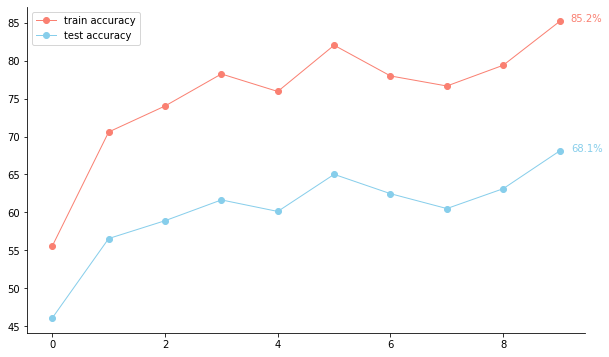

In [131]:
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
train_acc, test_acc, pred_test, target_test = train(net, criterion, optimizer, reduced_train_data_loader, test_data_loader, n_epochs)

plot_train_test_acc(train_acc, test_acc)

In [133]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [134]:
# Confusion Matrix
class_names=classes
confusion_mtx = confusion_matrix(target_test, pred_test)
print("confusion matrix=\n",confusion_mtx)

confusion matrix=
 [[622  29 105   0  25   2   6  10 130  71]
 [  3 908   7   0   3   0   9   2   8  60]
 [ 28   7 713   2  91  31  56  37  19  16]
 [ 28  28 200  44 119 186 235  71  30  59]
 [ 13   6  91   7 726  16  54  64   8  15]
 [ 16  14 178  38  75 433 108  98  11  29]
 [  4   9  69   2  40  10 849   6   4   7]
 [ 11   7  58   3  38  35  12 791   4  41]
 [ 14  40  23   2   8   1   9   2 852  49]
 [  5  80   6   0   2   2   7   6  20 872]]


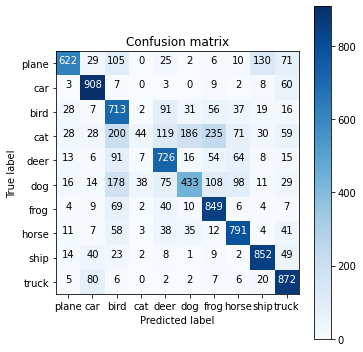

In [135]:
plot_confusion_matrix(confusion_mtx, class_names)    

### Using Data Augmentation in order to increase the dog and cat classes dataset

In [136]:
def data_augmentation(image):
  images = np.array([])
  images = Rotation(image, n_new_img=3, rotating_factor=20)
  images1 = flip(image, n_new_img=2)
  images = np.append(images, images1, axis=0)
  images2 = Scale(image, zoom_factor=0.3, n_new_img=2)
  images = np.append(images, images2, axis=0)
  images3 = Brightness(image, _brightness_range=[0.4,1.5], n_new_img=2)
  images = np.append(images, images3, axis=0)
  return images

In [ ]:
data_augmentation(image)

In [137]:
# testing
images1 = image.reshape(1, 3, 1090, 1600)
images = data_augmentation(image)
# plot_image(images, n_images=8)

In [138]:
image.shape

(1, 1090, 1600, 3)

In [158]:
dogs = np.array([5]*9)
cats = np.array([3]*9)

In [141]:
count_dog = 0
count_cat = 0

for i in range(len(reduced_data_labels_agg)):
  if index2label[reduced_data_labels_agg[i]] == 'dog':
    count_dog += 1
  elif index2label[reduced_data_labels_agg[i]] == 'cat':
    count_cat += 1  
print(count_dog, count_cat)    

500 500


In [155]:
reduced_data_array_agg.shape

(41000, 3, 32, 32)

In [ ]:
n_dog = 0
n_cat = 0
data_array_agg_fixed = np.array([])
data_labels_agg_fixed = np.array([])

for i in range(len(reduced_data_labels_agg)):
  image = reduced_data_array_agg[i].reshape(1, 32, 32, 3)
  if data_array_agg_fixed.shape == (0, ):
    data_labels_agg_fixed = reduced_data_labels_agg[i]
    data_array_agg_fixed = reduced_data_array_agg[i]
    
  else:
    data_array_agg_fixed = np.append(data_array_agg_fixed, reduced_data_array_agg[i], axis=0)
    data_labels_agg_fixed = np.append(data_labels_agg_fixed, reduced_data_labels_agg[i])
    
    if index2label[reduced_data_labels_agg[i]] == 'dog':
      n_dog += 1
      if n_dog <= 500:
        images = data_augmentation(image)
        images = images.reshape(9, 3, 32, 32)
        for j in range(9):
          data_array_agg_fixed = np.append(data_array_agg_fixed, images[j], axis=0)
        data_labels_agg_fixed = np.append(data_labels_agg_fixed, dogs)
    elif index2label[reduced_data_labels_agg[i]] == 'cat':
      n_cat += 1
      if n_cat <= 500:
        images = data_augmentation(image)
        images = images.reshape(9, 3, 32, 32)
        for j in range(9):
          data_array_agg_fixed = np.append(data_array_agg_fixed, images[j], axis=0)
        data_labels_agg_fixed = np.append(data_labels_agg_fixed, cats)

In [165]:
data_array_agg_fixed = np.array(data_array_agg_fixed)
data_labels_agg_fixed = np.array(data_labels_agg_fixed)

In [166]:
data_array_agg_fixed = data_array_agg_fixed.reshape((-1, 3, 32, 32))

In [168]:
train_data_loader_new = to_dataloader(data_array_agg_fixed, data_labels_agg_fixed, batch_size=128)

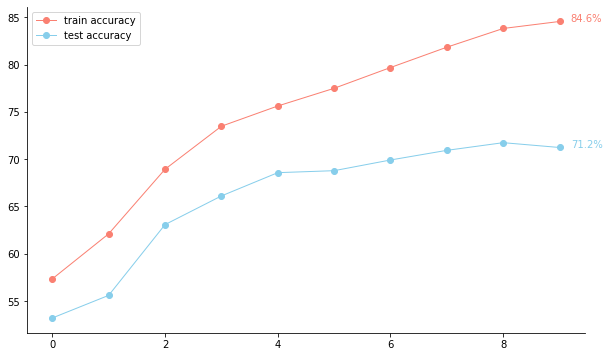

In [169]:
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
train_acc, test_acc, pred_test, target_test = train(net, criterion, optimizer, train_data_loader_new, test_data_loader, n_epochs)

plot_train_test_acc(train_acc, test_acc)

In [170]:
# Confusion Matrix
class_names=classes
confusion_mtx = confusion_matrix(target_test, pred_test)
print("confusion matrix=\n",confusion_mtx)

confusion matrix=
 [[785  30  45   4   5   0   2   2  84  43]
 [ 11 923   5   0   0   1   1   0  14  45]
 [ 76  14 735  13  43  35  26  23  19  16]
 [ 45  36 193 208  83 190  87  83  37  38]
 [ 40  10 126   8 639  29  33  87  21   7]
 [ 28  22 163  51  36 531  28 104  22  15]
 [ 16  25  87  13  28  20 760  14  22  15]
 [ 24  11  62   3  24  44   2 799   5  26]
 [ 52  31   9   1   1   0   1   5 882  18]
 [ 21  87   7   1   1   0   0   4  18 861]]


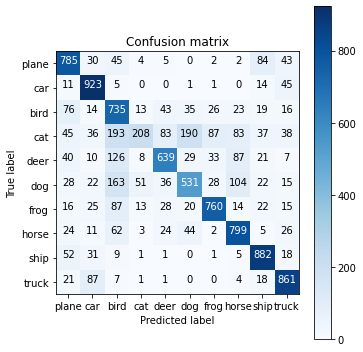

In [171]:
plot_confusion_matrix(confusion_mtx, class_names)    